In [37]:
import sys; sys.path.append("..") 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.utility import loadfile, savefile, exists
from src.dataprocessing import *
from src import rnn

## load data

In [38]:
# Define variables
input_var   = ["FT-3061-2", "FT-3061-3", "FT-3061-4", "FT-3062-1"]
output_var  = ["TT-3061-3", "TT-3061-5", "LT-3061-2"]
process_var = input_var + output_var

In [39]:
min_len = 100
continuous_path = './data/3_continuous'

cts_list = []
i = 1
while exists(f"{continuous_path}/cts_{min_len}/dataset {min_len}_{i}.csv"):
    cts_df = loadfile(continuous_path, f"cts_{min_len}/dataset {min_len}_{i}", 'csv', print_msg=False)
    cts_list.append(cts_df)
    i += 1

In [40]:
update = False

# Seq2Seq layer

In [67]:
target_list = cts_list

# history size and future size
history_size = 40
future_size = 10
step = 1

# variable selection
history_var = process_var
future_var = output_var

history_num = len(history_var)
future_num = len(future_var)

# data to series
history_series = []
future_series = []
for i in range(len(target_list)):
    history, future = data2series(target_list[i], history_size, history_var, future_size, future_var,
                                step, start_idx=0, end_idx=None)
    if not i:
        history_series = history
        future_series = future
    else:
        history_series = np.concatenate([history_series, history], axis=0)
        future_series = np.concatenate([future_series, future], axis=0)
        
# supervised attention factor
delta = 1.5
att_type = 'exp'
factor = rnn.super_attention(delta, future_size, future_num, att_type)
        
# test data split        
test_size = 0.2
test_num = -1

# model structure
num_layers_list = [1, 2]
num_neurons_list = [20, 40, 60, 80]
dense_layers = 1
dense_neurons = 50
model_list = ['seq2seq_gru', 'att_seq2seq_gru', 'datt_seq2seq_gru']

iteration_list = [x for x in range(1,3)]
i=0
for iteration in iteration_list:
    for num_layers in num_layers_list:
        for num_neurons in num_neurons_list:
            for model_type in model_list: 
                model_num = iteration
                model_name = f"{history_size}_{future_size}_{num_layers}_{num_neurons}_{dense_layers}_{dense_neurons}_{model_type}_{att_type}_{delta}_{model_num}"
                result = loadfile('./result', model_name, file_type='csv', header=1, print_msg=False)
                result.columns = ['R2_TT-3061-3', 'R2_TT-3061-5', 'R2_LT-3061-2', 'R2_MEAN', 'NRMSE_TT-3061-3', 'NRMSE_TT-3061-5', 'NRMSE_LT-3061-2', 'NRMSE_MEAN']
                time_steps = pd.DataFrame([f't+{i+1}' for i in range(future_size)]+['mean'], columns=['step'])
                result = pd.concat([result, time_steps], axis=1)
                result['iteration'] = iteration
                result['num_layers'] = num_layers
                result['num_neurons'] = num_neurons
                result['model_type'] = model_type
                if not i:
                    result_reshape = result
                else:
                    result_reshape = pd.concat([result_reshape, result], axis=0)
                i += 1

In [68]:
result_reshape[(result_reshape['step']=='mean')&(result_reshape['R2_MEAN']>0.7)].sort_values(by='R2_MEAN', ascending=False)

,R2_TT-3061-3,R2_TT-3061-5,R2_LT-3061-2,R2_MEAN,NRMSE_TT-3061-3,NRMSE_TT-3061-5,NRMSE_LT-3061-2,NRMSE_MEAN,step,iteration,num_layers,num_neurons,model_type
10,0.641202,0.796793,0.902302,0.780099,8.754373,7.811266,4.715471,7.093703,mean,2,2,20,datt_seq2seq_gru
10,0.684978,0.782032,0.865874,0.777628,8.260520,7.983649,5.527684,7.257284,mean,2,1,20,datt_seq2seq_gru
10,0.640787,0.799997,0.840720,0.760501,8.942161,7.723563,6.051948,7.572557,mean,1,2,20,att_seq2seq_gru
10,0.623844,0.797191,0.844241,0.755092,9.001390,7.804355,5.961583,7.589109,mean,1,1,20,seq2seq_gru
10,0.598988,0.797386,0.865486,0.753953,9.399673,7.800791,5.550919,7.583794,mean,2,1,20,att_seq2seq_gru
10,0.626059,0.777986,0.850757,0.751601,9.151701,8.137324,5.860377,7.716467,mean,2,1,40,att_seq2seq_gru
10,0.614009,0.797830,0.841208,0.751016,9.160929,7.753905,6.009022,7.641285,mean,2,2,40,datt_seq2seq_gru
10,0.611283,0.769805,0.856906,0.745998,9.289163,8.258297,5.683463,7.743641,mean,2,1,20,seq2seq_gru
10,0.599117,0.742782,0.869308,0.737069,9.388811,8.710904,5.344149,7.814621,mean,1,1,20,datt_seq2seq_gru
10,0.568767,0.773862,0.848200,0.730276,9.661661,8.174291,5.875236,7.903729,mean,1,1,40,datt_seq2seq_gru


## Figure 1

R2 results


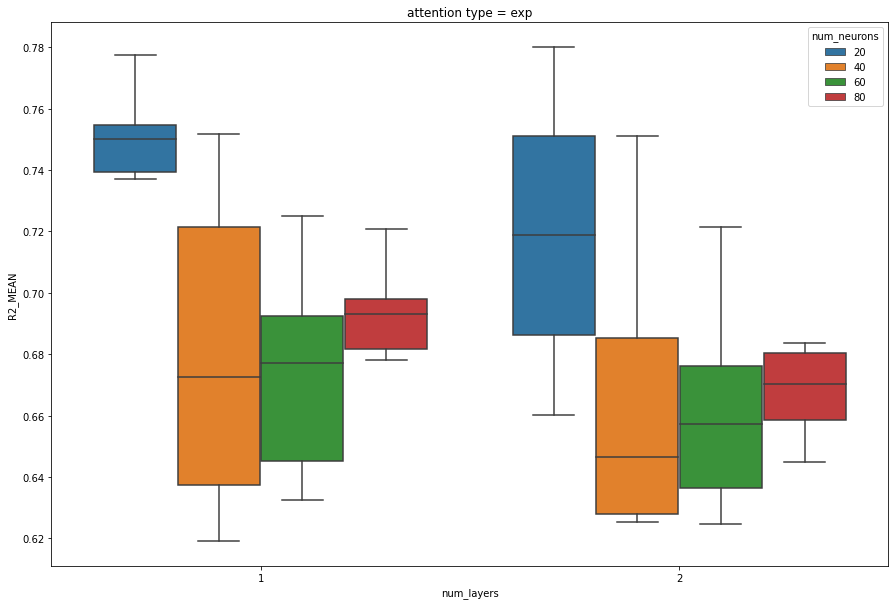

<Figure size 432x288 with 0 Axes>

In [51]:
data = result_reshape

plot_var = ['R2_MEAN']

print("R2 results")
plt.figure(figsize=(15*len(plot_var), 10))
for i, var in enumerate(plot_var):
    plt.subplot(len(plot_var), 1, i+1)
    plot_data = data[data['step']=='mean']
    sns.boxplot(x='num_layers', y=var, hue='num_neurons', data=plot_data, notch=False, showfliers = False)
    # plt.ylim(-0.01, 0.3)
    plt.title(f"attention type = {att_type}")
    
figure_name = f'layer_neuron_comparison_future_{future_size}_DA_seq2seq_r2'
if not exists(f'./figure/{figure_name}.png') or update:
    savefile(_, './figure', figure_name, 'figure')
    
plt.show()
plt.tight_layout()

## Figure 2

R2 results


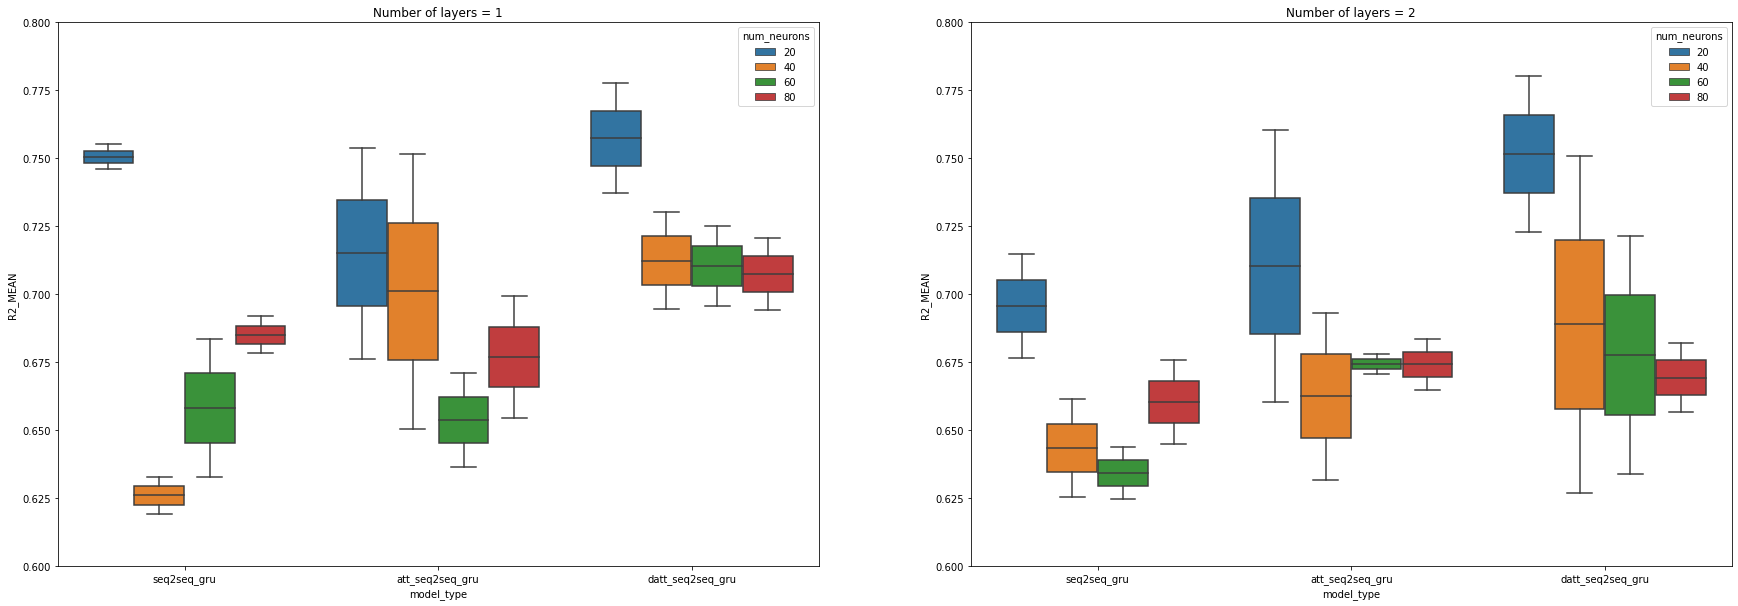

<Figure size 432x288 with 0 Axes>

In [53]:
data = result_reshape

plot_var = [1, 2]

print("R2 results")
plt.figure(figsize=(15*len(plot_var), 10))
for i, num_layers in enumerate(plot_var):
    plt.subplot(1, len(plot_var), i+1)
    plot_data = data[(data['step']=='mean') & (data['num_layers']==num_layers)]
    sns.boxplot(x='model_type', y='R2_MEAN', hue='num_neurons', data=plot_data, notch=False, showfliers = False)
    plt.ylim(0.6, 0.8)
    plt.title(f"Number of layers = {num_layers}")
    
figure_name = f'layer_neuron_model_comparison_future_{future_size}_r2'
if not exists(f'./figure/{figure_name}.png') or update:
    savefile(_, './figure', figure_name, 'figure')
    
plt.show()
plt.tight_layout()

# Dense layer

In [60]:
target_list = cts_list

# history size and future size
history_size = 40
future_size = 10
step = 1

# variable selection
history_var = process_var
future_var = output_var

history_num = len(history_var)
future_num = len(future_var)

# data to series
history_series = []
future_series = []
for i in range(len(target_list)):
    history, future = data2series(target_list[i], history_size, history_var, future_size, future_var,
                                step, start_idx=0, end_idx=None)
    if not i:
        history_series = history
        future_series = future
    else:
        history_series = np.concatenate([history_series, history], axis=0)
        future_series = np.concatenate([future_series, future], axis=0)
        
# supervised attention factor
delta = 1.5
att_type = 'exp'
factor = rnn.super_attention(delta, future_size, future_num, att_type)
        
# test data split        
test_size = 0.2
test_num = -1

# model structure
num_layers = 1
num_neurons = 40
dense_layers_list = [1, 2]
dense_neurons_list = [20, 40, 60, 80]
model_list = ['seq2seq_gru', 'att_seq2seq_gru', 'datt_seq2seq_gru']

iteration_list = [x for x in range(1,2)]
i=0
for iteration in iteration_list:
    for dense_layers in dense_layers_list:
        for dense_neurons in dense_neurons_list:
            for model_type in model_list: 
                model_num = iteration
                model_name = f"{history_size}_{future_size}_{num_layers}_{num_neurons}_{dense_layers}_{dense_neurons}_{model_type}_{att_type}_{delta}_{model_num}"
                result = loadfile('./result', model_name, file_type='csv', header=1, print_msg=False)
                result.columns = ['R2_TT-3061-3', 'R2_TT-3061-5', 'R2_LT-3061-2', 'R2_MEAN', 'NRMSE_TT-3061-3', 'NRMSE_TT-3061-5', 'NRMSE_LT-3061-2', 'NRMSE_MEAN']
                time_steps = pd.DataFrame([f't+{i+1}' for i in range(future_size)]+['mean'], columns=['step'])
                result = pd.concat([result, time_steps], axis=1)
                result['iteration'] = iteration
                result['dense_layers'] = dense_layers
                result['dense_neurons'] = dense_neurons
                result['model_type'] = model_type
                if not i:
                    result_reshape = result
                else:
                    result_reshape = pd.concat([result_reshape, result], axis=0)
                i += 1

In [66]:
result_reshape[(result_reshape['step']=='mean')&(result_reshape['R2_MEAN']>0.7)].sort_values(by='R2_MEAN', ascending=False)

,R2_TT-3061-3,R2_TT-3061-5,R2_LT-3061-2,R2_MEAN,NRMSE_TT-3061-3,NRMSE_TT-3061-5,NRMSE_LT-3061-2,NRMSE_MEAN,step,iteration,dense_layers,dense_neurons,model_type
10,0.643773,0.774076,0.882981,0.766944,8.767684,8.163619,5.170053,7.367119,mean,1,2,20,datt_seq2seq_gru
10,0.574409,0.778999,0.842079,0.731829,9.650259,8.097416,5.980863,7.909512,mean,1,1,80,datt_seq2seq_gru
10,0.511736,0.805416,0.873466,0.730206,10.215622,7.619272,5.359621,7.731505,mean,1,2,60,datt_seq2seq_gru
10,0.544733,0.762220,0.849726,0.718893,9.954472,8.448076,5.880948,8.094499,mean,1,1,80,att_seq2seq_gru
10,0.562217,0.762330,0.828642,0.717730,9.831464,8.460249,6.261153,8.184288,mean,1,1,40,att_seq2seq_gru
10,0.553324,0.774308,0.824589,0.717407,9.940721,8.233271,6.304911,8.159634,mean,1,2,80,att_seq2seq_gru
10,0.533784,0.752908,0.860219,0.715637,9.968188,8.548492,5.622464,8.046381,mean,1,1,20,datt_seq2seq_gru
10,0.574426,0.784202,0.788026,0.715552,9.561101,8.033481,7.010748,8.201777,mean,1,1,60,datt_seq2seq_gru
10,0.539464,0.770288,0.818566,0.709439,10.005062,8.262531,6.408851,8.225481,mean,1,2,80,datt_seq2seq_gru
10,0.530507,0.780594,0.798231,0.703111,10.142362,8.094828,6.761610,8.332933,mean,1,1,80,seq2seq_gru


## Figure 1

R2 results


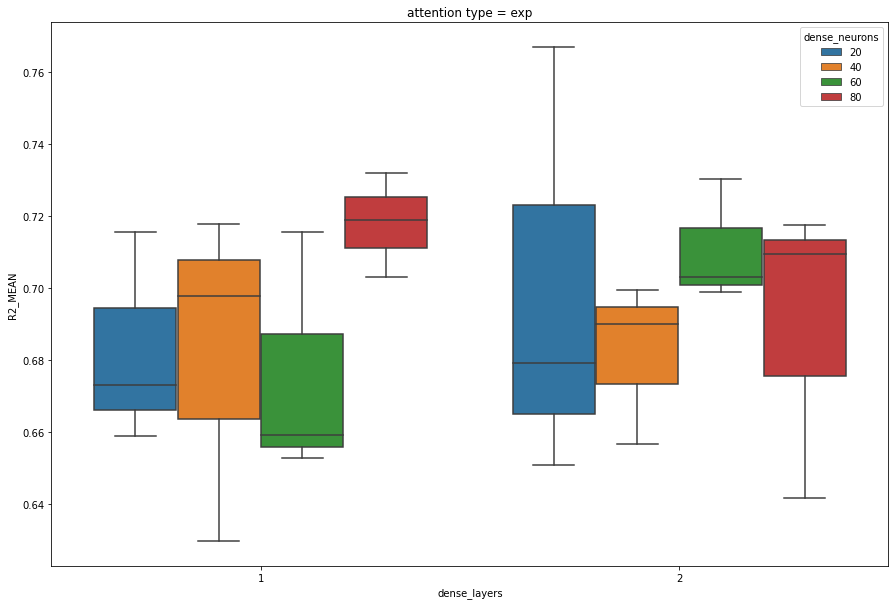

<Figure size 432x288 with 0 Axes>

In [61]:
data = result_reshape

plot_var = ['R2_MEAN']

print("R2 results")
plt.figure(figsize=(15*len(plot_var), 10))
for i, var in enumerate(plot_var):
    plt.subplot(len(plot_var), 1, i+1)
    plot_data = data[data['step']=='mean']
    sns.boxplot(x='dense_layers', y=var, hue='dense_neurons', data=plot_data, notch=False, showfliers = False)
    # plt.ylim(-0.01, 0.3)
    plt.title(f"attention type = {att_type}")
    
figure_name = f'dense_layer_neuron_comparison_future_{future_size}_DA_seq2seq_r2'
if not exists(f'./figure/{figure_name}.png') or update:
    savefile(_, './figure', figure_name, 'figure')
    
plt.show()
plt.tight_layout()

## Figure 2

R2 results


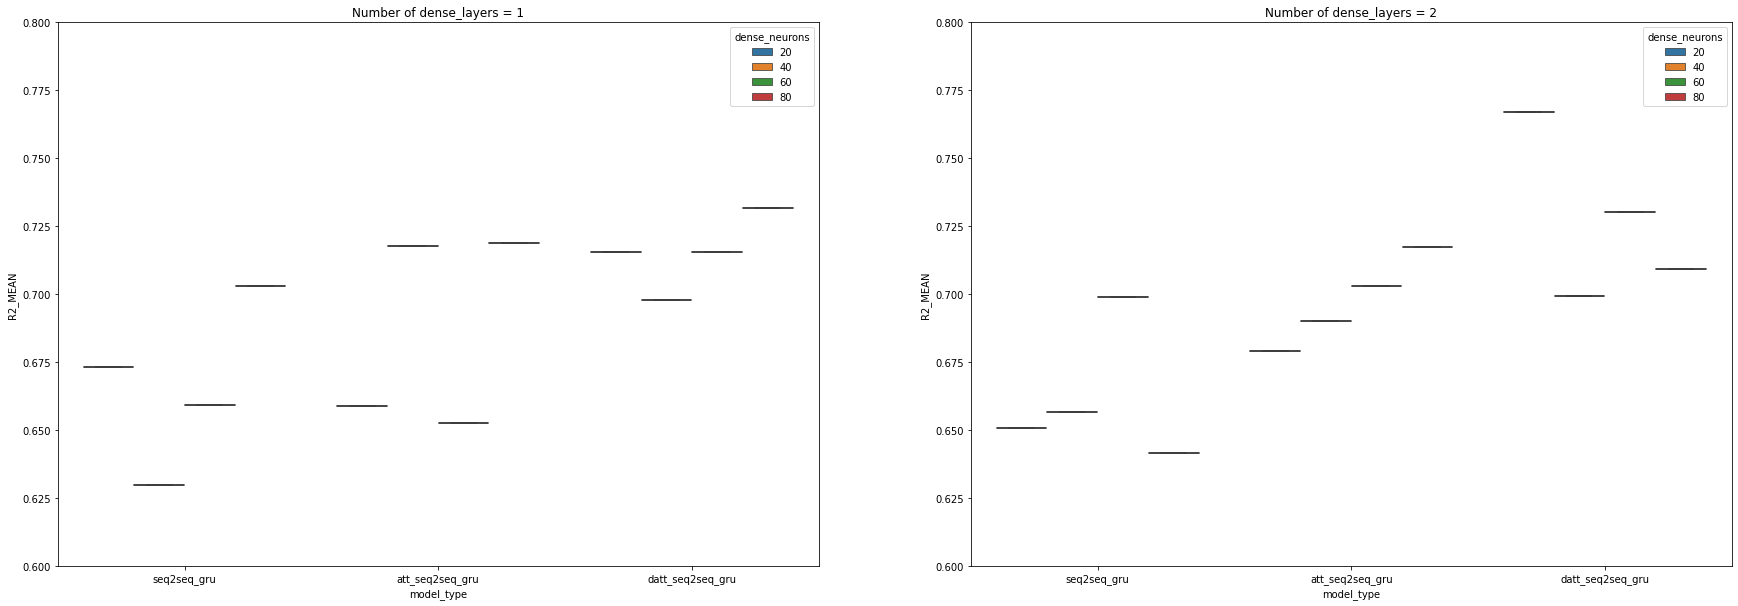

<Figure size 432x288 with 0 Axes>

In [59]:
data = result_reshape

plot_var = [1, 2]

print("R2 results")
plt.figure(figsize=(15*len(plot_var), 10))
for i, dense_layers in enumerate(plot_var):
    plt.subplot(1, len(plot_var), i+1)
    plot_data = data[(data['step']=='mean') & (data['dense_layers']==dense_layers)]
    sns.boxplot(x='model_type', y='R2_MEAN', hue='dense_neurons', data=plot_data, notch=False, showfliers = False)
    plt.ylim(0.6, 0.8)
    plt.title(f"Number of dense_layers = {dense_layers}")
    
figure_name = f'dense_layer_neuron_model_comparison_future_{future_size}_r2'
if not exists(f'./figure/{figure_name}.png') or update:
    savefile(_, './figure', figure_name, 'figure')
    
plt.show()
plt.tight_layout()